In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from skimage.color import rgb2gray
import skimage.morphology as morp
from skimage.filters.rank import equalize
from sklearn.utils import shuffle

# Allow image embeding in notebook
%matplotlib inline

In [2]:
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".png")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels


# Load training and testing datasets.
ROOT_PATH = "C:/Users/Luke/Desktop/dataset"
train_data_dir = os.path.join(ROOT_PATH, "C:/Users/Luke/Desktop/cv_dataset/train")
test_data_dir = os.path.join(ROOT_PATH, "C:/Users/Luke\Desktop/cv_dataset/test")

images, labels = load_data(train_data_dir)

In [3]:
images,labels =  shuffle(images, labels)

In [4]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 28
Total Images: 4195


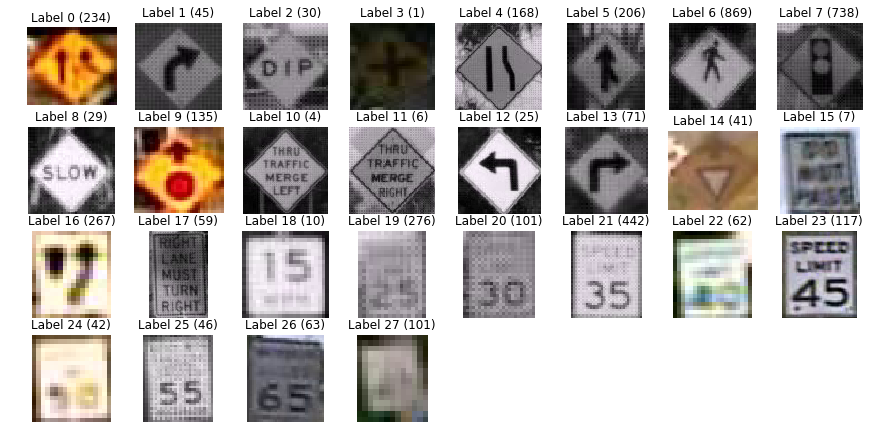

In [5]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

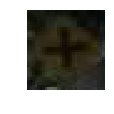

In [6]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 3)

In [7]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (16, 13, 3), min: 0, max: 193
shape: (51, 51, 3), min: 0, max: 183
shape: (27, 25, 3), min: 0, max: 255
shape: (64, 55, 3), min: 0, max: 255
shape: (45, 41, 3), min: 14, max: 255


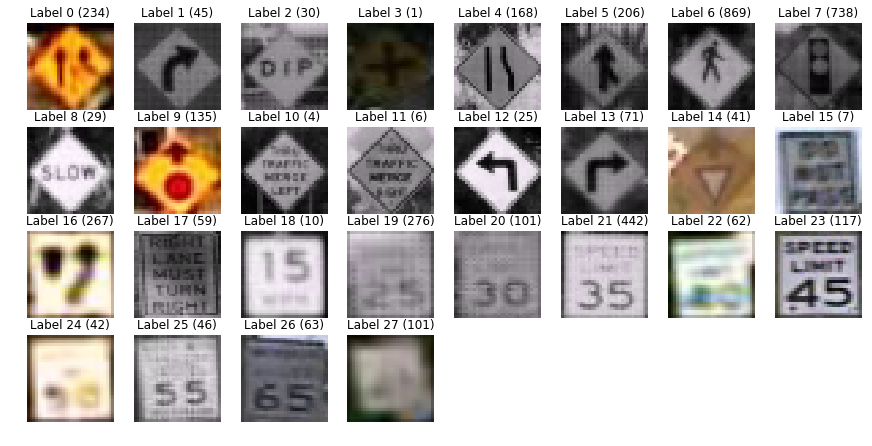

In [8]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]
display_images_and_labels(images32, labels)

In [9]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.0, max: 0.7491881127450979
shape: (32, 32, 3), min: 0.0047324984681372095, max: 0.7041475183823529
shape: (32, 32, 3), min: 0.0024730009191176335, max: 0.9970377604166666
shape: (32, 32, 3), min: 0.03023897058823559, max: 0.9449448529411766
shape: (32, 32, 3), min: 0.1300819546568628, max: 1.0


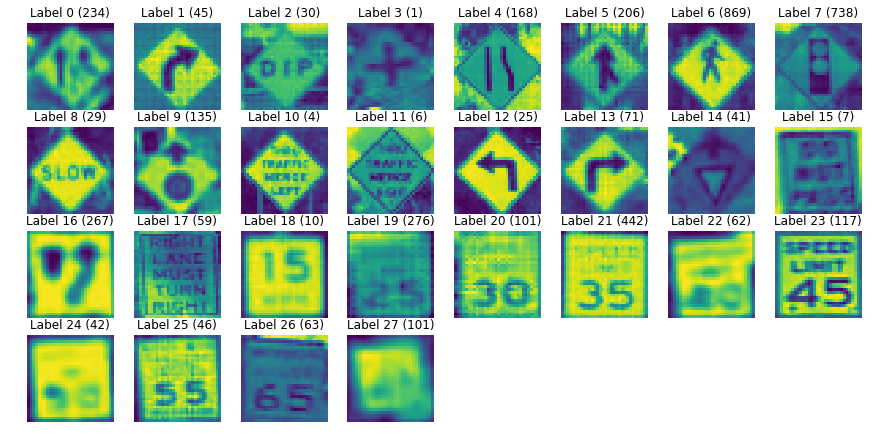

In [10]:
grey_images = []
for image in images32:
    grey_images.append(rgb2gray(image))
display_images_and_labels(grey_images, labels)

In [11]:
for image in grey_images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32), min: 0.03453625919117674, max: 0.7303539950980392
shape: (32, 32), min: 0.0047324984681372095, max: 0.6836757536764706
shape: (32, 32), min: 0.10160193962545963, max: 0.842016825980392
shape: (32, 32), min: 0.03179357536764736, max: 0.8329434313725491
shape: (32, 32), min: 0.14657497549019613, max: 0.9552947178500306


In [12]:
def local_histo_equalize(image):
    kernel = morp.disk(30)
    img_local = equalize(image, selem=kernel)
    return img_local

c:\users\luke\appdata\local\programs\python\python36\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


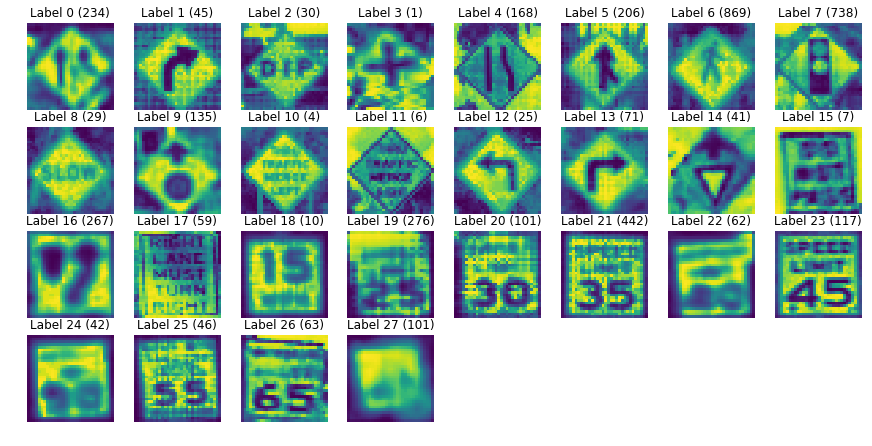

In [13]:
equal_images = []
for image in grey_images:
    equal_images.append(local_histo_equalize(image))
display_images_and_labels(equal_images, labels)

In [14]:
def image_normalize(image):
    image = np.divide(image, 255)
    return image

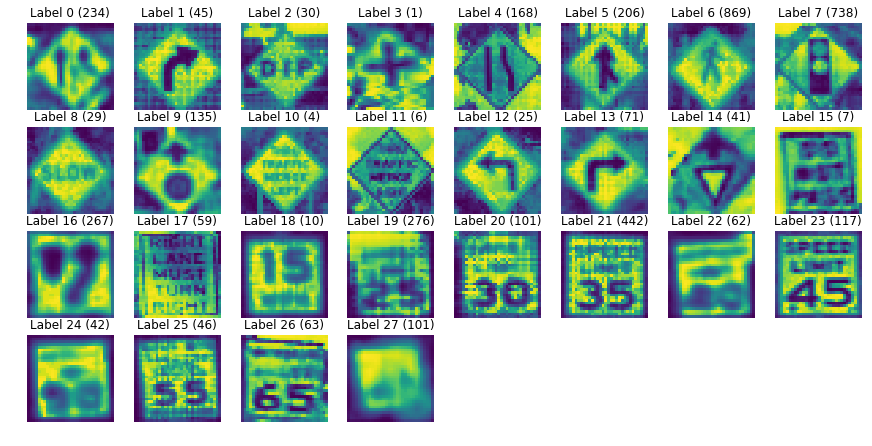

In [15]:
normal_images = []
for image in equal_images:
    normal_images.append(image_normalize(image))
display_images_and_labels(normal_images, labels)

In [16]:
labels_a = np.array(labels)
images_a = np.array(normal_images)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (4195,) 
images:  (4195, 32, 32)


In [17]:
# Create a graph to hold the model.
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():
    # Placeholders for inputs and labels.
    images_ph = tf.placeholder(tf.float32, [None, 32, 32])
    labels_ph = tf.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.contrib.layers.flatten(images_ph)

    # Fully connected layer. 
    # Generates logits of size [None, 62]
    logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function. 
    # Cross-entropy is a good choice for classification.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = labels_ph))

    # Create training op.
    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    # And, finally, an initialization op to execute before training.
    # TODO: rename to tf.global_variables_initializer() on TF 0.12.
    init = tf.global_variables_initializer()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

Instructions for updating:
Use the retry module or similar alternatives.
images_flat:  Tensor("Flatten/flatten/Reshape:0", shape=(?, 1024), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


In [18]:
# Create a session to run the graph we created.
session = tf.Session(graph=graph)

# First step is always to initialize all variables. 
# We don't care about the return value, though. It's None.
_ = session.run([init])

In [19]:
for i in range(201):
    _, loss_value = session.run([train, loss], 
                                feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Loss: ", loss_value)

Loss:  4.3574696
Loss:  2.9746242
Loss:  2.7081084
Loss:  2.5134902
Loss:  2.3633249
Loss:  2.256536
Loss:  2.1727042
Loss:  2.1044965
Loss:  2.048406
Loss:  2.001473
Loss:  1.9615514
Loss:  1.9270656
Loss:  1.896872
Loss:  1.8701416
Loss:  1.8462387
Loss:  1.8246815
Loss:  1.805108
Loss:  1.7872226
Loss:  1.7707882
Loss:  1.75561
Loss:  1.7415293


In [20]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [grey_images[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

[21, 7, 7, 14, 7, 7, 6, 20, 16, 14]
[ 7  6  7 14  7  7  6  7 16  6]


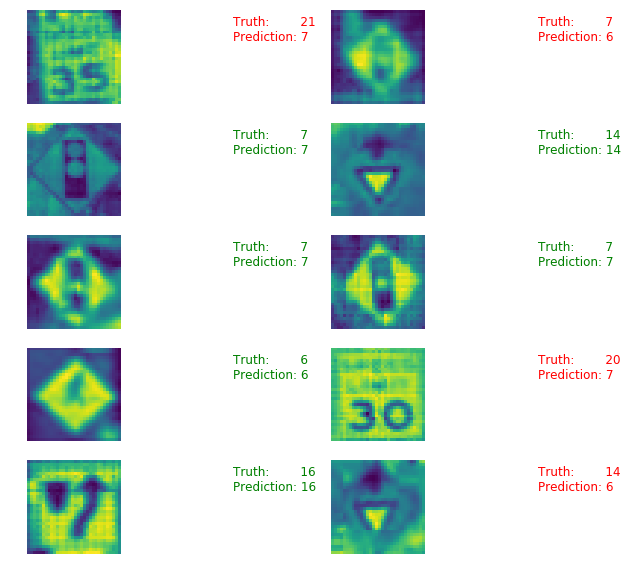

In [21]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(70, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])

In [22]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)

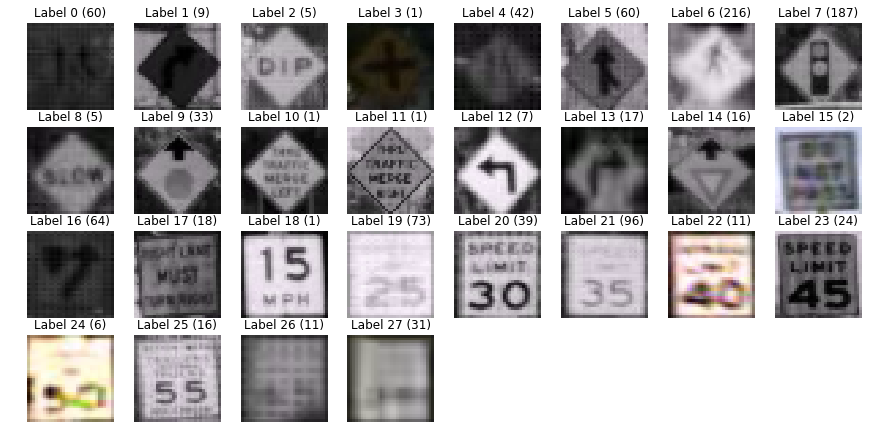

In [23]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

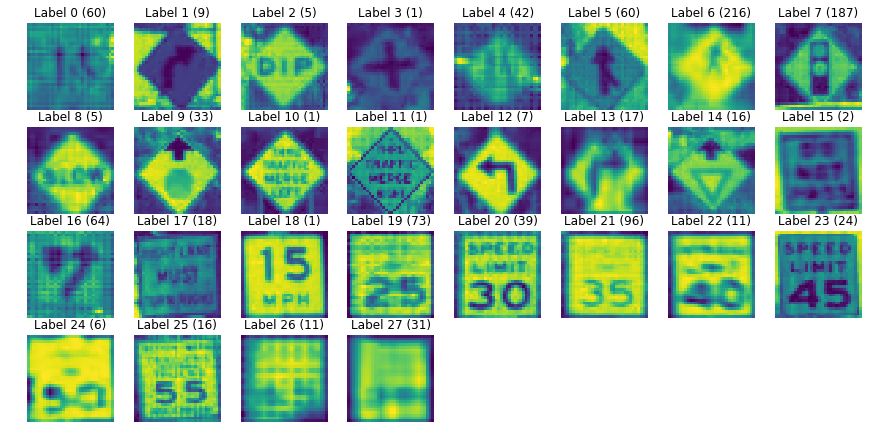

In [24]:
test_grey_images = []
for image in test_images32:
    test_grey_images.append(rgb2gray(image))
display_images_and_labels(test_grey_images, test_labels)

c:\users\luke\appdata\local\programs\python\python36\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


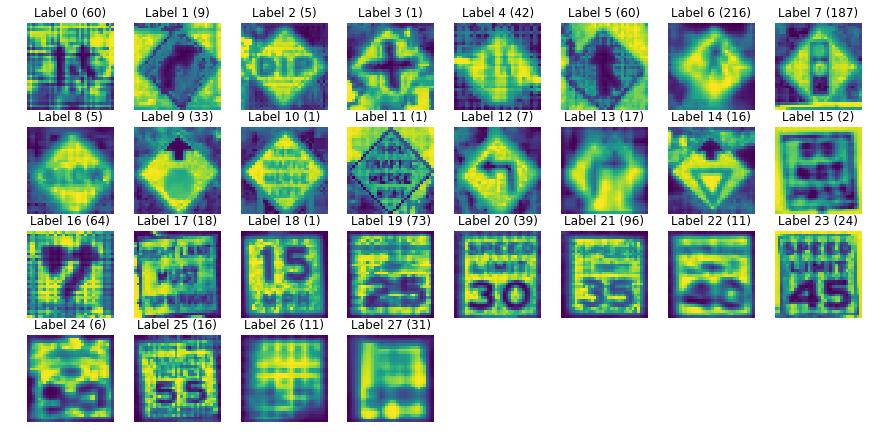

In [25]:
test_equal_images = []
for image in test_grey_images:
    test_equal_images.append(local_histo_equalize(image))
display_images_and_labels(test_equal_images, test_labels)

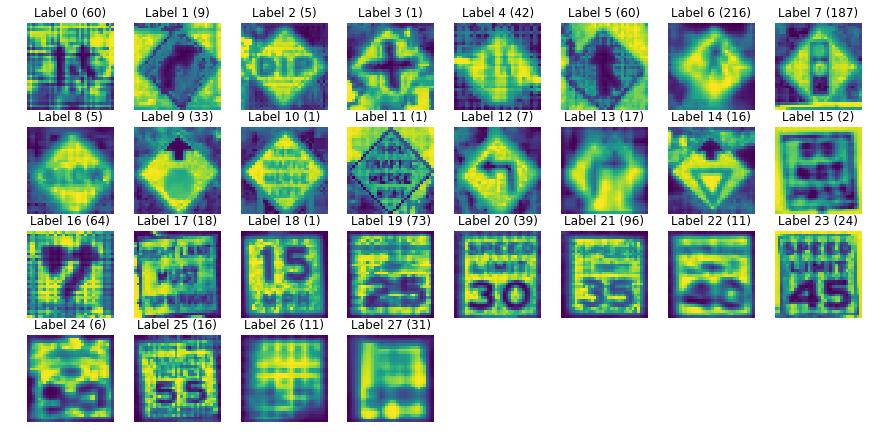

In [26]:
test_normal_images = []
for image in test_equal_images:
    test_normal_images.append(image_normalize(image))
display_images_and_labels(test_normal_images, test_labels)

In [27]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_grey_images})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.604


In [28]:
# Close the session. This will destroy the trained model.
session.close()